# Catholic School Enrollment Trends 

(I may add more documentation and commentary to this script in the future.)

By Kenneth Burchfiel

Released under the MIT License

This script visualizes and maps Catholic school enrollment changes over time (as indicated by NCES Private School Universe Survey data) at the state and county level.

Many of the interactive charts, maps, and tables created within this script can be viewed on [this Google Sites page](https://sites.google.com/view/catholic-enrollment-trends/home).

## Data accuracy notes and disclaimer

A comparison of the enrollment totals produced within this project to National Catholic Education Association (NCEA) statistics from 2017-2018 to 2021-2022 ([available here](https://nceatalk.org/wp-content/uploads/2023/05/Data_Brief_22_Catholic_School_Enrollment_v4.pdf)) and for 2012-2013 ([available here](https://web.archive.org/web/20240623163426/https://www.ncea.org/NCEA/NCEA/Who_We_Are/About_Catholic_Schools/Catholic_School_Data/Enrollment_and_Staffing.aspx)) indicates that the yearly enrollment totals calculated within this project are often <span style="color:red">**lower than the actual values**</span>. This is most likely because a significant proportion of Parent School Surveys are not answered by schools. <span style="color:red">**In addition, the drop in response rates from 2011-2012 to 2019-2020 may have exaggerated the enrollment declines observed by this script.**</span> (See response rates for recent school years below.)

My hope is that, despite the flaws in this data caused by low response rates, these analyses can still indicate which counties, dioceses, and states have higher or lower Catholic school enrollment growth relative to their peers. (However, it's possible that these relative rankings are *also* skewed by changes in response rates from year to year.)

In addition, some incorrect/outdated county codes were encountered within the original datasets; code was added in to correct these issues, but some inaccuracies may remain. This is another reason to interpret county-level data within this script with caution. 

Base-weighted total frame response rates by year: (These rates encompass all schools in the PSS, not just Catholic schools. Catholic school response rates may differ significantly from these averages.)

[2011-2012](https://nces.ed.gov/pubs2014/2014351.pdf): 91.8%

[2013-2014](https://nces.ed.gov/pubs2017/2017066.pdf): 80.6%

[2015-2016](https://nces.ed.gov/pubs2017/2017066.pdf): 69.2%

[2017-2018](https://nces.ed.gov/pubs2019/2019074.pdf): 76.6%

[2019-2020](https://nces.ed.gov/pubs2022/2022021.pdf): 73.3%

[2021-2022](https://nces.ed.gov/pubs2024/2024011.pdf): 76.8%



# Importing data

This project makes use of Private School Universe Survey (PSS) data collected by the National Center for Educational Statistics (NCES). This data can be found at https://nces.ed.gov/surveys/pss/pssdata.asp. I retrieved this data by downloading the ZIP files within the Data --> Text column for school years that I was interested in, then extracting them and copying their .csv and .txt files into the original_pss_data folder. 

Note that the NCES website requires you to agree to the following terms before this data can be downloaded:

    "NCES DATA USAGE AGREEMENT
    
    Under law, public use data collected and distributed by the National Center 
    for Education Statistics (NCES) may be used only for statistical purposes. 
    Any effort to determine the identity of any reported case by public-use 
    data users is prohibited by law. Violations are subject to Class E felony 
    charges of a fine up to $250,000 and/or a prison term up to 5 years.
    NCES does all it can to assure that the identity of data subjects cannot 
    be disclosed. All direct identifiers, as well as any characteristics that 
    might lead to identification, are omitted or modified in the dataset to 
    protect the true characteristics of individual cases. Any intentional 
    identification or disclosure of a person or institution violates the 
    assurances of confidentiality given to the providers of the information. 
    Therefore, users shall:
    
    Use the data in any dataset for statistical purposes only.
    
    Make no use of the identity of any person or institution discovered 
    inadvertently, and advise NCES of any such discovery.
    
    Not link any dataset with individually identifiable data from other 
    NCES or non-NCES datasets.
    To proceed you must signify your agreement to comply with the 
    above-stated statutorily based requirements. This window will close 
    and you can now download the file."

Given these requirements, I am not including the original PSS files within the public version of this code (although you may download them yourself from the NCES website). In addition, I chose not to include identifiers like school names or addresses in this notebook's output. 

However, in order to make this script easier for other users to run, I have made an aggregated version of this dataset available. This dataset, saved as catholic_school_enrollment_by_year.csv, does not contain any school names, addresses, or phone numbers, and can thus be shared publicly. (I confirmed this with an NCES representative via email.)


In [1]:
import time
program_start_time = time.time()
import pandas as pd
import geopandas
pd.set_option('display.max_columns', 1000)
import numpy as np
import plotly.express as px
from choropleth_map_functions import create_map_and_screenshot
# This file was sourced from my Python for Nonnprofits project, 
# available at:
# https://github.com/kburchfiel/pfn_2/tree/main/Mapping

# Configuring settings for static Plotly exports:
chart_width = 1000
chart_aspect_ratio = 9/16
chart_height = chart_width * chart_aspect_ratio
chart_scale = 4
print(chart_width, chart_height)
import folium

# This function will allow DataFrames to get saved as interactive
# HTML files.
from itables import to_html_datatable
# Removing these interactive files' size limit:
import itables.options as opt; opt.maxBytes = 0
# From https://mwouts.github.io/itables/downsampling.html

import os

1000 562.5


Reading county names into our script:

The private school survey does provide county names; however, because only the names (and not the county/county equivalent types) are provided, relying on this data alone can sometimes result in ambiguities. (For instance, Virginia has both a Fairfax County and a city of Fairfax, so using only the 'FAIRFAX' name in the dataset can lead to confusion).

Therefore, we'll import a more comprehensive dataset below from the Census website (link: https://www2.census.gov/geo/docs/reference/codes2020/national_county2020.txt) that contains full county/county equivalent names (e.g. 'Fairfax County' and 'Fairfax City'). We can then merge these names into our private school survey dataset using state and county codes as keys.

In [2]:
download_codes = False # Set this variable to True to download a new copy
# of state and county codes from the Census website.

if download_codes == True: 
    df_state_county_codes = pd.read_csv(
        f'https://www2.census.gov/geo/docs/reference/\
codes2020/national_county2020.txt', sep = '|')
    # Creating a column that combines 
    # county and state names:
    # (Some 'COUNTYNAME' values were not in title case (e.g. 'Fairfax city'),
    # so I added a str.title() call to rectify this.
    df_state_county_codes['County & State'] = (
        df_state_county_codes['COUNTYNAME'].str.title() + ', ' +
    df_state_county_codes['STATE'])

    df_state_county_codes.to_csv(
        'state_and_county_codes_from_census.csv', 
        index = False)

# This step isn't strictly necessary if download_codes is set to True. However,
# choosing to always read in the DataFrame from a .csv file helps ensure that 
# the initial column types will always be the same.
df_state_county_codes = pd.read_csv(
    'state_and_county_codes_from_census.csv')

# Renaming county and state column codes to match the equivalent field names
# within a combined school survey dataset that we'll create shortly:

df_state_county_codes.rename(columns = {'STATEFP':'State ANSI Code', 
'COUNTYFP':'County Code', 'STATE':'State Abbreviation \
From Census Code File'}, inplace = True)

df_state_county_codes

,State Abbreviation From Census Code File,State ANSI Code,County Code,COUNTYNS,COUNTYNAME,CLASSFP,FUNCSTAT,County & State
0,AL,1,1,161526,Autauga County,H1,A,"Autauga County, AL"
1,AL,1,3,161527,Baldwin County,H1,A,"Baldwin County, AL"
2,AL,1,5,161528,Barbour County,H1,A,"Barbour County, AL"
3,AL,1,7,161529,Bibb County,H1,A,"Bibb County, AL"
4,AL,1,9,161530,Blount County,H1,A,"Blount County, AL"
...,...,...,...,...,...,...,...,...
3230,PR,72,153,1804557,Yauco Municipio,H1,A,"Yauco Municipio, PR"
3231,UM,74,300,1802699,Midway Islands,H4,N,"Midway Islands, UM"
3232,VI,78,10,2378248,St. Croix Island,H4,N,"St. Croix Island, VI"
3233,VI,78,20,2378249,St. John Island,H4,N,"St. John Island, VI"


Importing a FIPS state code table: (This table was sourced from the US Census website at https://www.census.gov/library/reference/code-lists/ansi/ansi-codes-for-states.html .)

In [3]:
df_state_fips = pd.read_csv('fips_state_code_table.csv')
# Renaming the FIPS code column as 'State ANSI Code' so that it can be more
# easily merged into our dataset:

df_state_fips.rename(
    columns = {'FIPS State Numeric Code':'State ANSI Code',
              'Name':'Full State Name',
              'Official USPS Code':'State'}, inplace = True)
df_state_fips.head()

,Full State Name,State ANSI Code,State
0,Alabama,1,AL
1,Alaska,2,AK
2,Arizona,4,AZ
3,Arkansas,5,AR
4,California,6,CA


In [4]:
pss_filenames = os.listdir('original_pss_data')
if '.ipynb_checkpoints' in pss_filenames:
    pss_filenames.remove('.ipynb_checkpoints')
pss_filenames

['pss1112_pu.txt',
 'pss1314_pu.csv',
 'pss1516_pu.csv',
 'pss1718_pu.csv',
 'pss1920_pu.csv',
 'pss2122_pu.csv']

Determining all school years for which we have data in the original_pss_data folder:

In [5]:
school_year_list = [file[3:5] + '-' + file[5:7] for file in pss_filenames]
# Sorting this list chronologically:
school_year_list.sort()
# Determining the earliest and latest years (which will be helpful for our data analysis):
earliest_sy = school_year_list[0]
latest_sy = school_year_list[-1]

second_to_last_sy = school_year_list[-2] # If surveys are released every 2
# years and there aren't any recent gaps in the datasets in 
# original_pss_data, this value will be the school year 2 years before
# the most recent one, thus allowing for a recent comparison metric.

# Storing additional school years as variables:
third_to_last_sy = school_year_list[-3]  
sixth_to_last_sy = school_year_list[-6]

# Adding these historical school years to a list:
# (We'll iterate through this list when creating several charts and maps.)
historical_sy_list = [second_to_last_sy, third_to_last_sy, sixth_to_last_sy]



print(school_year_list)
print(earliest_sy, latest_sy)
print(historical_sy_list)



['11-12', '13-14', '15-16', '17-18', '19-20', '21-22']
11-12 21-22
['19-20', '17-18', '11-12']


In [6]:
county_code_list = pd.read_csv(
    'original_pss_data/pss2122_pu.csv', low_memory = False)[
['PSTANSI','PCNTY','PCNTNM']].drop_duplicates(subset = ['PCNTNM', 'PSTANSI']
).reset_index(drop=True)#.sort_values(['PSTANSI', 'PCNTNM']) 
# A few counties had more than one code, but the above code will retain only
# one code for each of them. (If those codes happened to be incorrect,
# we'll encounter failed merges later on--so a better approach, which I might
# apply in the future, would be to get a list of authoritative state and 
# county codes and then merge those in instead.)
county_code_list

,PSTANSI,PCNTY,PCNTNM
0,1,55,ETOWAH
1,1,125,TUSCALOOSA
2,1,89,MADISON
3,1,73,JEFFERSON
4,1,103,MORGAN
...,...,...,...
2066,28,31,COVINGTON
2067,48,487,WILBARGER
2068,48,15,AUSTIN
2069,40,1,ADAIR


Creating a DataFrame that stores the diocese names corresponding to each code within the `DIOCESE` column:

I copied these codes from the 2021-2022 PSS codebook (https://nces.ed.gov/surveys/pss/pdf/codebook2021_22.pdf) into a local text file. (Note: this code assumes that these diocesan codes remained the same throughout all the years for which I retrieved data.) The following code imports this file; reads each line into a list of dictionaries; and then converts that list into a DataFrame.

In [7]:
with open('pss_diocese_codes.txt') as file:
    text = file.readlines()

Each line within this file begins with a diocese code, followed by 'Diocese' (or 'Archdiocese'); 'of'; and the city and state of the diocesan seat (or seats) that correspond(s) to that code. Therefore, we can extract the codes and names by splitting each line into a list; storing the first entry within that list as a code; and the third and following entries as a diocese name. (This approach will still be compatible with diocese names of differing word counts (e.g. 'Denver' vs. 'Colorado Springs').

In [8]:
diocese_dict_list = []
for line in text:
    diocese_line = line.strip().split(' ')
    diocese_dict = {
        'code':diocese_line[0], 
        'Diocese':' '.join(diocese_line[3:])}
    diocese_dict_list.append(diocese_dict)

This list of dictionaries can easily be converted into a DataFrame:

In [9]:
df_dioceses = pd.DataFrame(diocese_dict_list)
# Creating an integer version of the code column that may prove useful
# when merging in this data:
df_dioceses['code_as_int'] = df_dioceses['code'].astype('int')
df_dioceses.to_csv('pss_diocese_code_list.csv', index = False)
df_dioceses

,code,Diocese,code_as_int
0,0101,"Birmingham, AL",101
1,0102,"Mobile, AL",102
2,0201,"Anchorage, AK",201
3,0202,"Fairbanks, AK",202
4,0203,"Juneau, AK",203
...,...,...,...
171,5502,"Green Bay, WI",5502
172,5503,"La Crosse, WI",5503
173,5504,"Madison, WI",5504
174,5505,"Superior, WI",5505


Ensuring that no duplicate diocese names or codes are present:

In [10]:
df_dioceses[df_dioceses['Diocese'].duplicated(keep=False)]

,code,Diocese,code_as_int


In [11]:
df_dioceses[df_dioceses['code_as_int'].duplicated(keep=False)]

,code,Diocese,code_as_int


Checking Catholic enrollment totals within the 21-22 dataset:

(This sum, 1,465,265, can be used to check the output of subsequent cells.)

In [12]:
# pd.read_csv(f'original_pss_data/pss2122_pu.csv', 
#             encoding = 'latin_1', low_memory = False).query("P440 == 1")['P305'].sum()

In [13]:
# pd.read_csv(f'original_pss_data/{pss_filenames[0]}', sep = '\t', encoding = 'latin_1', low_memory = False)['diocese'].value_counts()

## Importing PSS data

In [14]:
pss_df_list = []
for filename in pss_filenames:
    #filename = 'pss1112_pu.txt'
    school_year = filename[3:5] + '-' + filename[5:7]
    starting_school_year = int(filename[3:5]) + 2000
    ending_school_year = starting_school_year + 1
    print(school_year, starting_school_year, ending_school_year)
    
    if 'txt' in filename: 
    # This text file is tab separated, so I needed to add '\t' as the 'sep' 
    # argument.
    # I also set the encoding to latin_1 after finding that the default
    # encoding argument didn't work.
        df_pss = pd.read_csv(f'original_pss_data/{filename}', 
                    sep = '\t', encoding = 'latin_1', low_memory = False)
    
    else: # Setting custom 'sep' and 'encoding' arguments wasn't necessary
        # in the case of .csv-formatted data.
        df_pss = pd.read_csv(
            f'original_pss_data/{filename}', encoding = 'latin_1',
            low_memory = False)
        # Setting the encoding to latin_1 is necessary for earlier
        # .csv files (e.g. the 13-14 and 15-16 datasets) and doesn't appear
        # to cause any issues for later datasets.
    
    # Creating a copy of this dataset that includes only Catholic schools:
    # (The 21-22 PSS codebook, which can be found at 
    # https://nces.ed.gov/surveys/pss/pdf/codebook2021_22.pdf , 
    # explains that a P440 value of 1 identifies a school as Catholic.)

    # Converting all columns to uppercase for consistency purposes:
    # (Different datasets have used different capitalization conventions.)
    df_pss.columns = [col.upper() for col in df_pss.columns]
    
    df_pss_c_full = df_pss.query("P440 == 1").copy().reset_index(drop=True)

    # df_pss_c_full_cols = df_pss_c_full.columns.copy()

    cols_to_keep = ['P305', 'P445', 'DIOCESE', 
                    'PCNTNM', 'PCNTY', 'PSTANSI']
    
    # Creating a condensed version of df_pss_c_full that contains only 
    # the fields we'll need for our analysis:
    df_pss_c_single_year = df_pss_c_full[cols_to_keep].copy()
    
    
    
    # The 2021-2022 codebook (https://nces.ed.gov/surveys/pss/pdf/codebook2021_22.pdf)
    # was used as a reference for the above code. It's possible, though, that 
    # at least some datasets from past years assigned different meanings 
    # to different column names.
    
    # Notes on these entries:
    # P305 stores total school enrollment values. The PSS dataset also stores
    # grade-level information, but we'll focus on just total enrollment
    # counts for now.
    # P445 stores "Type of Catholic School" values. 1 refers to 'Parochial';
    # 2 refers to 'Diocesan'; and 3 refers to 'Private.'
    
    # 'pcnty22' stores both county and state information.
    
    # pstabb refers to the state found within scholos' mailing address.
    # It would have been ideal to use 'pl_stabb' instead (which shows
    # where schools are actually located', but many schools didn't report
    # this information, strangely enough. 
    
    # Although pcntnm, pstansi, and pcnty don't start with the pl_ 
    # ('physical_location') prefix, they too refer to 
    # schools' physical locations (rather than mailing locations) as 
    # clarified within the 2021-22 NCES codebook.
    
    df_pss_c_single_year['School Year'] = school_year
    df_pss_c_single_year['Starting School Year'] = starting_school_year
    df_pss_c_single_year['Ending School Year'] = ending_school_year

    # # Adding county codes for a selected year to the dataset:
    # df_pss_c_single_year = df_pss_c_single_year.merge(
    #     county_code_list, on = ['PSTANSI', 'PCNTNM'], how = 'left')
    
    pss_df_list.append(df_pss_c_single_year)

11-12 2011 2012
13-14 2013 2014
15-16 2015 2016
17-18 2017 2018
19-20 2019 2020
21-22 2021 2022


## Combining and reformatting this data

In [15]:
# Combining these single-year tables into one DataFrame:
df_pss_c = pd.concat([df for df in pss_df_list]).reset_index(drop=True)

# Reformatting the combined dataset: (applying these changes to the
# entire DataFrame at once should be slightly more efficient than 
# making the same changes to each of the single-year DataFrames)

# Making sure that the codes within the diocese column are stored
# as integers (which will be necessary for an upcoming merge
# to work successfully):

df_pss_c.rename(
    columns = {'P305':'Enrollment', 
               # 'pstabb':'Mailing State',
               # 'pl_stabb':'Physical State',
               #'pcnty22':'County and State',
               'DIOCESE':'code_as_int',
               'PSTANSI':'State ANSI Code',
               'PCNTY':'County Code',
               'PCNTNM':'County'}, inplace = True)


df_pss_c['code_as_int'] = (
    df_pss_c['code_as_int'].astype('int'))

# Creating a new column that shows the value corresponding to each
# code within P445:
# (These codes were retrieved from
# https://nces.ed.gov/surveys/pss/pdf/codebook2021_22.pdf ).
# I ended up not incorporating this value into the pivot table
# created by this code in order to keep the output simpler.
df_pss_c['Type'] = df_pss_c['P445'].map(
    {1:'Parochial',2:'Diocesan',3:'Private'})

# Merging in state names and abbreviations from df_state_fips:
# I had originally planned to use the pstabb (mailing state column)
# and/or pl_stabb (physical state columns) as sources of state data,
# but neither option was ideal: mailing states can sometimes differ
# from the states in whihc schools are actually located
# (as I confirmed using 2011-2012 data),
# and pl_stabb data was missing for many rows. Therefore, I instead
# used the pstansi column (which stores the ANSI codes corresponding
# to schools' actual locations) as the source of state data. 
# Merging in df_state_fips allowed me to list the state name 
# and abbreviation corresponding to each code.

df_pss_c = df_pss_c.merge(
    df_state_fips, on = 'State ANSI Code', how = 'left')



df_pss_c = df_pss_c.merge(
    df_dioceses[['code_as_int', 'Diocese']], 
    on = 'code_as_int', how = 'left')
                                                  


    
print(f"{len(df_pss_c.query('Diocese.isna()'))} diocese values, \
{len(df_pss_c.query('State.isna()'))} state values, and \
{len(df_pss_c.query('County.isna()'))} county values \
are missing from the DataFrame.")
    


# Converting all-caps county names to title case:
# (This change will also capitalize 's' when it follows an apostrophe,
# resulting in county names like "Prince George'S". Thus, a str.replace()
# call was added in order to make this letter lowercase.
df_pss_c['County'] = df_pss_c['County'].str.title(
).str.replace("'S", "'s")


df_pss_c['PSS_County_and_State'] = (
    df_pss_c['County'] 
    + ' (' + df_pss_c['State'] + ')')

df_pss_c.drop(['code_as_int', 'P445'], axis = 1, inplace = True)

# df_pss_c

0 diocese values, 0 state values, and 0 county values are missing from the DataFrame.


## Evaluating nationwide enrollment data

In [18]:
df_nationwide_enrollment_by_year = df_pss_c.pivot_table(
    index = 'School Year', 
    values = 'Enrollment', aggfunc = 'sum').reset_index()
df_nationwide_enrollment_by_year

,School Year,Enrollment
0,11-12,1931451
1,13-14,1746431
2,15-16,1579253
3,17-18,1606816
4,19-20,1421896
5,21-22,1465265


(See the introduction to this notebook and/or the project's readme file for an important disclaimer regarding these enrollment figures.)

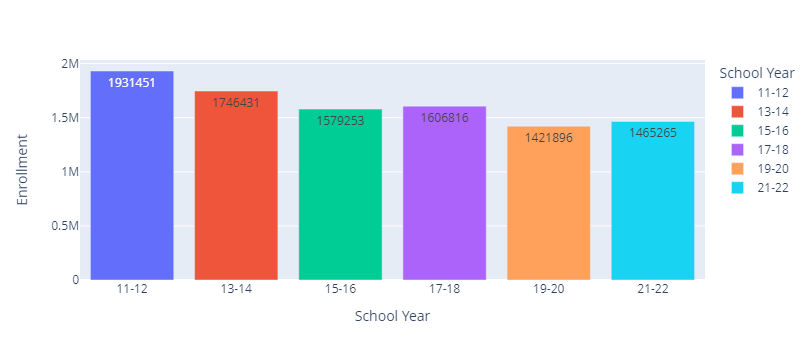

In [25]:
fig_nationwide_enrollment = px.bar(
    df_nationwide_enrollment_by_year,
    x = 'School Year', y = 'Enrollment',
    color = 'School Year', text_auto = '.0f')
fig_nationwide_enrollment.update_xaxes(type = 'category')
# Based on Pracheta's response at https://stackoverflow.com/a/64424308/13097194
# and https://plotly.com/python/reference/layout/xaxis/#layout-xaxis-type
fig_nationwide_enrollment

## Identifying and correcting incorrect/outdated county codes

One issue with df_pss_c is that certain counties have more than one associated code, as demonstrated by the following pivot table:

In [16]:
df_counties_to_check = df_pss_c.drop_duplicates(
    subset = ['State', 'County', 'County Code']).pivot_table(
    index = ['State', 'County'], values = 'Enrollment', 
    aggfunc = 'count').reset_index().sort_values(
    'Enrollment', ascending = False).query("Enrollment > 1")
df_counties_to_check['PSS_County_and_State'] = (
df_counties_to_check['County'] 
+ ' (' + df_counties_to_check['State'] + ')')
df_counties_to_check

,State,County,Enrollment,PSS_County_and_State
1139,VA,Fairfax,3,Fairfax (VA)
1230,WI,Ozaukee,2,Ozaukee (WI)
995,PA,Monroe,2,Monroe (PA)
863,NY,Westchester,2,Westchester (NY)
658,MO,St. Louis,2,St. Louis (MO)
468,MA,Middlesex,2,Middlesex (MA)
1016,SC,Beaufort,2,Beaufort (SC)
877,OH,Cuyahoga,2,Cuyahoga (OH)
484,MD,Howard,2,Howard (MD)
475,MD,Baltimore,2,Baltimore (MD)


This will prove problematic when attempting to merge full county names into our dataset; the merge will either fail to work for entries with incorrect codes or (even worse) merge the wrong counties into the rows.

Therefore, in the following cells, we'll identify potential incorrect codes; use the Census state and county code dataset retrieved earlier to identify which codes are correct; and then replace the incorrect codes with the correct ones.

Creating a list of all codes (whether correct or incorrect) for each of the state/county pairs in the above list:

In [17]:
counties_to_check_list = df_counties_to_check['PSS_County_and_State'].to_list()

code_discrepancies = df_pss_c.query(
    "PSS_County_and_State in @counties_to_check_list").sort_values(
    'School Year').drop_duplicates(
    ['PSS_County_and_State', 'County Code'], keep = 'last')[
['PSS_County_and_State', 'State ANSI Code', 'County Code', 
 'School Year']].sort_values(['PSS_County_and_State', 'County Code'])
code_discrepancies

,PSS_County_and_State,State ANSI Code,County Code,School Year
29108,Baltimore (MD),24,5,21-22
29092,Baltimore (MD),24,510,21-22
14203,Baltimore City (MD),24,3,15-16
14275,Baltimore City (MD),24,510,15-16
32489,Beaufort (SC),45,13,21-22
16630,Beaufort (SC),45,53,15-16
30161,Cuyahoga (OH),39,35,21-22
16087,Cuyahoga (OH),39,55,15-16
32620,Fairfax (VA),51,59,21-22
17011,Fairfax (VA),51,153,15-16


**Integer versions of correct codes** (from Census county/state dataset that we imported earlier):

(Note that there are two valid codes for 'Baltimore', 'Fairfax', 
and 'St. Louis', as there are both *county* and *city* regions associated
with these names. Therefore, we won't need to make any changes to those rows
(except in the case of one incorrect Fairfax City code).)


Baltimore County, MD: 5

Baltimore City, MD: 510

Beaufort County, SC: 13

Cuyahoga County, OH: 35

Fairfax County, VA: 59

Fairfax City, VA: 600

(I confirmed within the original 15-16 dataset that the school with a County Code of 153 and a County of Fairfax (VA) was located in Fairfax City, so this school's county code should be switched to 600, not 59.)

Howard County, MD: 27

Middlesex County, MA: 17

Monroe County, PA: 89

Ozaukee County, WI: 89

St. Louis County, MO: 189

St. Louis City, MO: 510

Westchester County, NY: 119



We can identify additional county codes that may require changes by attempting to merge our county codes into the dataset, then identifying rows with missing 'County and State' values (which indicate a failure to find a match between the county/state codes in the PSS file and those in the Census file):

In [18]:
df_pss_c.merge(
    df_state_county_codes[['State ANSI Code', 
    'County Code', 'County & State', 
'State Abbreviation From Census Code File']], 
    on = ['State ANSI Code', 'County Code'], how = 'left').query(
    "`County & State`.isna()")[
    ['County', 'County Code', 
    'State ANSI Code', 'School Year', 'State']]

,County,County Code,State ANSI Code,School Year,State
5556,Shannon,113,46,11-12,SD
5558,Shannon,113,46,11-12,SD
11341,Shannon,113,46,13-14,SD
11342,Shannon,113,46,13-14,SD
16664,Ogala Lakota,113,46,15-16,SD
16665,Ogala Lakota,113,46,15-16,SD


[Wikipedia](https://en.wikipedia.org/wiki/Oglala_Lakota_County,_South_Dakota#History) notes that Shannon County was renamed to Oglala Lakota County (not 'Ogala' Lakota, as some of the above rows would suggest). The code for this county in the Census dataset is now 102; it most likely changed in order to keep South Dakota's county codes in alphabetical order. (No South Dakota county currently uses the old code of 113, thankfully.) 

By changing these county codes to the new code of 102, we'll be able to ensure that these rows get merged successfully with our Census county table.

## Revising county codes

I found that merging df_pss_c with df_state_county_codes failed to work for several South Dakota rows. I realized that this was because the name of the county represented in these rows had changed from Shannon to Oglala Lakota; as a result of these changes, its Census county code also changed from 113 to 102. Therefore, I added in the following code to make all of these rows 102, thus preventing errors during the merge with df_state_county_codes.



In [19]:
# Creating a list of values that will help correct inaccurate codes
# within df_pss_c:
# The first, second, third, and entries within each list refer to the incorrect
# county code; the code to which it should be changed; the corresponding
# state; and the county's name, respectively. 
# (Including the county name
# will help prevent us from accidentally changing valid county entries that
# happen to have the same codes as the first entries in this list.

code_correction_list = [
    [113, 102, 46, 'Ogala Lakota'], 
    [113, 102, 46, 'Shannon'], # Oglala County was referred to as both 
    # 'Shannon' and 'Ogala [sic] Lakota' in earlier versions of the dataset,
    # so I created entries for each name in order for the following code
    # to correctly process both of them.
    [3, 510, 24, 'Baltimore City'],
    [53, 13, 45, 'Beaufort'], 
    [55, 35, 39, 'Cuyahoga'], 
    [153, 600, 51, 'Fairfax'],
    [69, 89, 42, 'Monroe'],
    [3, 27, 24, 'Howard'], 
    [27, 17, 25, 'Middlesex'], 
    [79, 89, 55, 'Ozaukee'], 
    [5, 119, 36, 'Westchester'],
]

code_correction_list

[[113, 102, 46, 'Ogala Lakota'],
 [113, 102, 46, 'Shannon'],
 [3, 510, 24, 'Baltimore City'],
 [53, 13, 45, 'Beaufort'],
 [55, 35, 39, 'Cuyahoga'],
 [153, 600, 51, 'Fairfax'],
 [69, 89, 42, 'Monroe'],
 [3, 27, 24, 'Howard'],
 [27, 17, 25, 'Middlesex'],
 [79, 89, 55, 'Ozaukee'],
 [5, 119, 36, 'Westchester']]

## Replacing incorrect county codes with correct ones

In [20]:
for i in range(len(code_correction_list)):
    incorrect_code = code_correction_list[i][0]
    correct_code = code_correction_list[i][1]
    state_code = code_correction_list[i][2]
    county_name = code_correction_list[i][3]
    incorrect_code, correct_code, state_code, county_name
    
    print(f"Now changing codes of {incorrect_code} for {county_name} \
(within state {state_code}) to {correct_code}.")
    
    incorrect_entry_count = len(
        df_pss_c.query("`County Code` == @incorrect_code \
& `State ANSI Code` == @state_code & County == @county_name"))
    print(f"{incorrect_entry_count} change(s) will be made.")
    
    df_pss_c['County Code'] = np.where(
        (df_pss_c['County Code'] == incorrect_code) 
             & (df_pss_c['State ANSI Code'] == state_code)
        & (df_pss_c['County'] == county_name)
        , correct_code, df_pss_c['County Code'])

    incorrect_entry_count = len(df_pss_c.query(
        "`County Code` == @incorrect_code \
& `State ANSI Code` == @state_code & County == @county_name"))
    print(f"{incorrect_entry_count} incorrect entries remain.\n")
    

Now changing codes of 113 for Ogala Lakota (within state 46) to 102.
2 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 113 for Shannon (within state 46) to 102.
4 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 3 for Baltimore City (within state 24) to 510.
1 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 53 for Beaufort (within state 45) to 13.
2 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 55 for Cuyahoga (within state 39) to 35.
1 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 153 for Fairfax (within state 51) to 600.
1 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 69 for Monroe (within state 42) to 89.
1 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 3 for Howard (within state 24) to 27.
1 change(s) will be made.
0 incorrect entries remain.

Now changing codes of 27 for Middlesex (within 

### Confirming that these changes were successful

There are still two entries for 'Fairfax', 'St. Louis', and 'Baltimore,' but that's OK, as we know that these can refer to both cities *and* counties.


In [21]:
df_pss_c.drop_duplicates(
    subset = ['State', 'County', 'County Code']).pivot_table(
    index = ['State', 'County'], values = 'Enrollment', 
    aggfunc = 'count').reset_index().sort_values(
    'Enrollment', ascending = False).query("Enrollment > 1")

,State,County,Enrollment
1139,VA,Fairfax,2
658,MO,St. Louis,2
475,MD,Baltimore,2


## Merging Census county data into df_pss_c

(Now that we've resolved the county code issues identified earlier, we can finally merge this data into our table.)

In [22]:
df_pss_c = df_pss_c.merge(
    df_state_county_codes[['State ANSI Code', 
    'County Code', 'County & State', 
'State Abbreviation From Census Code File']], 
    on = ['State ANSI Code', 'County Code'], how = 'left')
# df_pss_c

## Confirming that a match was found for each row

In [23]:
len(df_pss_c.query("`County & State`.isna()"))

0

## Creating and saving a pivoted version of this data

In [24]:
# Creating a pivot table that shows Catholic K-12 
# enrollment totals by county and year:

df_pss_c_pivot = df_pss_c.pivot_table(
    index = ['School Year', 'State', 'Diocese',
             'County & State', 'State ANSI Code', 'County Code'], 
    values = 'Enrollment', 
    aggfunc = 'sum').reset_index()

# Making sure that both our county code and state ANSI code columns
# are formatted as integers: (this will be important for a later merge.)
for column in ['County Code', 'State ANSI Code']:
    df_pss_c_pivot[column] = df_pss_c_pivot[
    column].astype('int')

df_pss_c_pivot

,School Year,State,Diocese,County & State,State ANSI Code,County Code,Enrollment
0,11-12,AK,"Anchorage, AK","Anchorage Municipality, AK",2,20,331
1,11-12,AK,"Anchorage, AK","Kodiak Island Borough, AK",2,150,93
2,11-12,AK,"Anchorage, AK","Matanuska-Susitna Borough, AK",2,170,57
3,11-12,AK,"Fairbanks, AK","Fairbanks North Star Borough, AK",2,90,491
4,11-12,AK,"Juneau, AK","Ketchikan Gateway Borough, AK",2,130,92
...,...,...,...,...,...,...,...
7055,21-22,WY,"Cheyenne, WY","Campbell County, WY",56,5,166
7056,21-22,WY,"Cheyenne, WY","Fremont County, WY",56,13,74
7057,21-22,WY,"Cheyenne, WY","Laramie County, WY",56,21,128
7058,21-22,WY,"Cheyenne, WY","Sheridan County, WY",56,33,66


In [25]:
df_pss_c_pivot['Enrollment'].sum()

9751112

In [26]:
df_pss_c_pivot.pivot_table(
    index = 'School Year', values = 'Enrollment', aggfunc = 'sum')

,Enrollment
School Year,
11-12,1931451
13-14,1746431
15-16,1579253
17-18,1606816
19-20,1421896
21-22,1465265


I used the following code to confirm that each diocese had only one code associated with it:

(For this code to run successfully, 'code_as_int' much be included within the `index` list when creating df_pss_c_county_pivot.)

In [27]:
# df_pss_c_pivot.drop_duplicates(
#     subset = ['Diocese', 'code_as_int']).pivot_table(
#     index = ['Diocese'], values = 'Enrollment', 
#     aggfunc = 'count').reset_index().sort_values(
#     'Enrollment', ascending = False).query("Enrollment > 1")

We'll now save this pivot table to a CSV file:

In [28]:
df_pss_c_pivot.to_csv(
    'output/tables/catholic_school_enrollment_by_year.csv', 
    index = False)

# Analyzing enrollment changes over time

We now have enrollment data available for multiple years, but we'll also want to see how enrollment has changed over time. Therefore, I added in the following function to calculate enrollment changes between different school years.

In [29]:
100*((2 / 3) -1)

-33.333333333333336

In [30]:
def create_enrollment_comparisons(df, region_col):
    '''This function allows annual enrollment data to be compared 
    to enrollment during other years. It does so by (1) creating a filtered
    copy of df that only contains data for a specific school year; 
    (2) renaming that copy's 'Enrollment' column to include the school year; 
    (3) merging this dataset into df; and (4) adding columns that compare 
    the past enrollment data to the year shown in the 'School Year' row.
    
    df: the DataFrame for which to calculate enrollment statistics.

    region_col: A column containing region names for region-specific data
    (e.g. 'County & State' for county-level data). This column will also 
    serve as a key when merging in enrollment data for past years.
    '''

    if len(df[df.duplicated(
        subset = ['School Year', region_col], keep = False)]) > 0:
        raise ValueError("Duplicate school year/region pairs found within \
the dataset! Remove these duplicates before running the function in order \
to prevent the merge operations in this function from creating incorrect \
enrollment totals.")

    # Filtering the DataFrame to include only the most recent school year:
    # (This will ensure that our enrollment comparisons only measure from
    # previous points in time to the current point in time, not the other
    # way around. For example, if we included all original years in our
    # output, we might end up evaluating 'growth' from 19-20 to 15-16,
    # which would produce negative numbers for regions that grew from
    # 15-16 to 19-20.)
    df_latest = df.query(
    "`School Year` == @latest_sy").copy().rename(
        columns = {'Enrollment':f'{latest_sy} Enrollment'})
    
    for sy in historical_sy_list:
        df_latest = df_latest.merge(
            df.query("`School Year` == @sy").rename(
            columns = {"Enrollment":f"{sy} Enrollment"})[
        [region_col, f"{sy} Enrollment"]], 
            on = region_col, how = 'left')
        df_latest[
        f'{sy} to {latest_sy} Enrollment % Change'] = 100*((
            df_latest[f'{latest_sy} Enrollment'] 
            / df_latest[f'{sy} Enrollment']) - 1)
        df_latest[
        f'{sy} to {latest_sy} Enrollment Change'] = (
            df_latest[f'{latest_sy} Enrollment'] 
            - df_latest[f'{sy} Enrollment'])

        # Calculating ranks and percentile for both the nominal 
        # enrollment change and enrollment % change columns:
        df_latest[
        f'{sy} to {latest_sy} Enrollment Change Rank'] = df_latest[
        f'{sy} to {latest_sy} Enrollment Change'].rank(
            ascending=False, method = 'min')
        
        df_latest[
        f'{sy} to {latest_sy} Enrollment Change Percentile'] = 100 * df_latest[
        f'{sy} to {latest_sy} Enrollment Change'].rank(
            pct=True, ascending=True, method='max')
        
        df_latest[
        f'{sy} to {latest_sy} Enrollment % Change Rank'] = (
            df_latest[
        f'{sy} to {latest_sy} Enrollment % Change'].rank(
            ascending=False, method = 'min'))
        
        df_latest[
        f'{sy} to {latest_sy} Enrollment % Change Percentile'] = (
            100 * df_latest[
            f'{sy} to {latest_sy} Enrollment % Change'].rank(
            pct=True, ascending=True, method='max'))

    return df_latest

## Calculating county-level enrollment changes and totals

Note: in order to create accurate calculations, we'll need to repivot our dataset to show just one row per county/school year pair. (Some counties have multiple rows for the same year within df_pss_c_pivot, either because certain counties belong to more than one diocese or because of potential reporting errors in the original dataset.) Otherwise, we'll end up with duplicated enrollment totals when running create_enrollment_comparisons().

In [31]:
df_pss_c_county_pivot = df_pss_c_pivot.pivot_table(
    index = ['County & State', 'School Year'], 
    values = 'Enrollment', aggfunc = 'sum').reset_index()
df_pss_c_county_pivot

,County & State,School Year,Enrollment
0,"Acadia Parish, LA",11-12,1975
1,"Acadia Parish, LA",13-14,1755
2,"Acadia Parish, LA",15-16,1389
3,"Acadia Parish, LA",17-18,1240
4,"Acadia Parish, LA",19-20,1500
...,...,...,...
6980,"Yuma County, AZ",13-14,271
6981,"Yuma County, AZ",15-16,560
6982,"Yuma County, AZ",17-18,620
6983,"Yuma County, AZ",19-20,897


In [32]:
df_pss_c_county_pivot = df_pss_c_pivot.pivot_table(
    index = ['County & State', 'School Year', 'County Code', 'State ANSI Code'], 
    values = 'Enrollment', aggfunc = 'sum').reset_index()

df_pss_c_county_pivot.to_csv('county_enrollment_by_year.csv', index = False)

df_pss_c_county_pivot

,County & State,School Year,County Code,State ANSI Code,Enrollment
0,"Acadia Parish, LA",11-12,1,22,1975
1,"Acadia Parish, LA",13-14,1,22,1755
2,"Acadia Parish, LA",15-16,1,22,1389
3,"Acadia Parish, LA",17-18,1,22,1240
4,"Acadia Parish, LA",19-20,1,22,1500
...,...,...,...,...,...
6980,"Yuma County, AZ",13-14,27,4,271
6981,"Yuma County, AZ",15-16,27,4,560
6982,"Yuma County, AZ",17-18,27,4,620
6983,"Yuma County, AZ",19-20,27,4,897


In [33]:
df_pss_c_county_pivot.pivot_table(
    index = 'School Year', values = 'Enrollment', 
    aggfunc = 'sum').reset_index()

,School Year,Enrollment
0,11-12,1931451
1,13-14,1746431
2,15-16,1579253
3,17-18,1606816
4,19-20,1421896
5,21-22,1465265


In [34]:
def export_df_to_csv_and_html(df_original, filename, round_val = 2):
    '''This function simplifies the process of saving a DataFrame to both a 
    .csv and interactive HTML file.
    
    df_original: the DataFrame to be saved.
    
    file_path: the desired path and filename for the file. 
    (Don't include .csv or .html 
    extensions; these will be added automatically.)

    round_val: the integer to pass to the round() function in order to 
    make floats easier to read. Set this value as 99 in order to disable 
    rounding.
    '''

    # Making a copy of df_original so as to ensure that the following
    # code does not affect it:

    df = df_original.copy()
    
    df.to_csv(
        f'{filename}.csv', 
        index = False)

    # Rounding all floats within the DataFrame:
    # (This will also cause integers to get converted to floats, but
    # these values should still appear as integers when the HTML file 
    # is viewed as a web browser.)
    if round_val != 99:
        df = df.round(round_val)

    # The following code is based on
    # https://mwouts.github.io/itables/html_export.html
    # and https://docs.python.org/3/tutorial/inputoutput.html.
    with open(f'{filename}.html', 'w') as file:
        file.write(to_html_datatable(df))

In [35]:
df_pss_c_county_pivot_latest = create_enrollment_comparisons(
    df_pss_c_county_pivot, 
    region_col = 'County & State')

county_pivot_filename = f'output/tables/{latest_sy}_catholic\
_enrollment_trends_by_county'

export_df_to_csv_and_html(df_pss_c_county_pivot_latest,
                          county_pivot_filename)

df_pss_c_county_pivot_latest

,County & State,School Year,County Code,State ANSI Code,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,"Acadia Parish, LA",21-22,1,22,1375,1500.0,-8.333333,-125.0,883.0,16.556291,730.0,31.031220,1240.0,10.887097,135.0,159.0,85.315985,311.0,71.189591,1975.0,-30.379747,-600.0,927.0,16.123188,786.0,28.894928
1,"Ada County, ID",21-22,1,16,2569,1863.0,37.895867,706.0,56.0,94.796594,141.0,86.754967,1855.0,38.490566,714.0,34.0,96.933086,131.0,87.918216,1729.0,48.582996,840.0,8.0,99.365942,83.0,92.572464
2,"Adair County, MO",21-22,1,29,72,80.0,-10.000000,-8.0,627.0,40.775781,764.0,27.814570,68.0,5.882353,4.0,422.0,60.873606,374.0,65.334572,67.0,7.462687,5.0,310.0,72.010870,270.0,75.634058
3,"Adams County, CO",21-22,1,8,626,419.0,49.403341,207.0,158.0,85.146641,113.0,89.403974,298.0,110.067114,328.0,80.0,92.657993,37.0,96.654275,484.0,29.338843,142.0,85.0,92.391304,140.0,87.409420
4,"Adams County, IL",21-22,1,17,813,817.0,-0.489596,-4.0,597.0,43.614002,580.0,45.222327,1299.0,-37.413395,-486.0,952.0,11.617100,960.0,10.873606,728.0,11.675824,85.0,115.0,89.673913,220.0,80.163043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,"Yolo County, CA",21-22,113,6,751,370.0,102.972973,381.0,105.0,90.160833,40.0,96.310312,395.0,90.126582,356.0,72.0,93.401487,48.0,95.631970,890.0,-15.617978,-139.0,737.0,33.333333,580.0,47.554348
1132,"York County, ME",21-22,31,23,141,139.0,1.438849,2.0,541.0,48.912015,528.0,50.141911,359.0,-60.724234,-218.0,870.0,19.237918,1051.0,2.416357,369.0,-61.788618,-228.0,802.0,27.445652,1065.0,3.623188
1133,"York County, NE",21-22,185,31,105,109.0,-3.669725,-4.0,597.0,43.614002,641.0,39.451277,169.0,-37.869822,-64.0,741.0,31.226766,964.0,10.501859,116.0,-9.482759,-11.0,400.0,63.858696,482.0,56.431159
1134,"York County, PA",21-22,133,42,873,1372.0,-36.370262,-499.0,996.0,5.865658,992.0,6.244087,540.0,61.666667,333.0,77.0,92.936803,91.0,91.635688,1720.0,-49.244186,-847.0,972.0,12.047101,984.0,10.960145


In [36]:
df_pss_c_county_pivot.pivot_table(
    index = 'School Year', values = 'Enrollment', 
    aggfunc = 'sum').reset_index()

,School Year,Enrollment
0,11-12,1931451
1,13-14,1746431
2,15-16,1579253
3,17-18,1606816
4,19-20,1421896
5,21-22,1465265


In [37]:
df_pss_c_county_pivot['Enrollment'].sum()

9751112

## Calculating state-level enrollment changes and totals

In [38]:
df_pss_c_state_pivot = df_pss_c_pivot.pivot_table(
    index = ['State', 'School Year'], 
    values = 'Enrollment', aggfunc = 'sum').reset_index()

df_pss_c_state_pivot.to_csv('state_enrollment_by_year.csv', index = False)

df_pss_c_state_pivot_latest = create_enrollment_comparisons(
    df_pss_c_state_pivot, region_col = 'State')

state_pivot_filename = f'output/tables/{latest_sy}_catholic\
_enrollment_trends_by_state'

export_df_to_csv_and_html(df_pss_c_state_pivot_latest,
                          state_pivot_filename)

df_pss_c_state_pivot_latest

,State,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,AK,21-22,1137,807,40.892193,330,30.0,43.137255,1.0,100.000000,1017,11.799410,120,14.0,74.509804,10.0,82.352941,1064,6.860902,73,5.0,92.156863,3.0,96.078431
1,AL,21-22,9174,8834,3.848766,340,29.0,45.098039,26.0,50.980392,10628,-13.680843,-1454,30.0,43.137255,36.0,31.372549,11953,-23.249393,-2779,25.0,52.941176,30.0,43.137255
2,AR,21-22,6285,5297,18.652067,988,19.0,64.705882,10.0,82.352941,6044,3.987426,241,13.0,76.470588,14.0,74.509804,7015,-10.406272,-730,13.0,76.470588,15.0,72.549020
3,AZ,21-22,20261,16629,21.841361,3632,7.0,88.235294,8.0,86.274510,18831,7.593861,1430,5.0,92.156863,12.0,78.431373,20446,-0.904822,-185,8.0,86.274510,8.0,86.274510
4,CA,21-22,162607,157646,3.146924,4961,3.0,96.078431,27.0,49.019608,185995,-12.574532,-23388,50.0,3.921569,34.0,35.294118,207317,-21.566008,-44710,49.0,5.882353,28.0,47.058824
5,CO,21-22,14294,14006,2.056262,288,31.0,41.176471,31.0,41.176471,13305,7.433296,989,9.0,84.313725,13.0,76.470588,17151,-16.657921,-2857,26.0,50.980392,21.0,60.784314
6,CT,21-22,18929,18136,4.372519,793,23.0,56.862745,25.0,52.941176,20597,-8.098267,-1668,33.0,37.254902,27.0,49.019608,31309,-39.541346,-12380,41.0,21.568627,46.0,11.764706
7,DC,21-22,6125,5029,21.793597,1096,16.0,70.588235,9.0,84.313725,4778,28.191712,1347,7.0,88.235294,3.0,96.078431,6166,-0.664937,-41,7.0,88.235294,7.0,88.235294
8,DE,21-22,5266,5162,2.014723,104,34.0,35.294118,32.0,39.215686,6127,-14.052554,-861,26.0,50.980392,38.0,27.450980,9554,-44.881725,-4288,31.0,41.176471,49.0,5.882353
9,FL,21-22,75992,74973,1.359156,1019,18.0,66.666667,33.0,37.254902,78202,-2.826015,-2210,35.0,33.333333,22.0,58.823529,80299,-5.363703,-4307,32.0,39.215686,10.0,82.352941


## Comparing states by enrollment changes from the earliest to the latest year in our dataset

(This comparison is based on nominal growth (e.g. the most recent enrollment minus the earliest enrollment) rather than percentage growth.)

In [39]:
df_pss_c_state_pivot_latest.sort_values(
    f'{earliest_sy} to {latest_sy} Enrollment Change', ascending = False)

,State,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
28,ND,21-22,7411,5582,32.766034,1829,12.0,78.431373,3.0,96.078431,4342,70.681713,3069,2.0,98.039216,1.0,100.000000,4583,61.706306,2828,1.0,100.000000,1.0,100.000000
13,ID,21-22,4138,3764,9.936238,374,27.0,49.019608,17.0,68.627451,3493,18.465502,645,11.0,80.392157,7.0,88.235294,3137,31.909468,1001,2.0,98.039216,2.0,98.039216
45,VA,21-22,26091,21170,23.245158,4921,4.0,94.117647,7.0,88.235294,23288,12.036242,2803,4.0,94.117647,9.0,84.313725,25531,2.193412,560,3.0,96.078431,5.0,92.156863
41,SD,21-22,7068,5417,30.478124,1651,13.0,76.470588,4.0,94.117647,5673,24.590164,1395,6.0,90.196078,4.0,94.117647,6725,5.100372,343,4.0,94.117647,4.0,94.117647
0,AK,21-22,1137,807,40.892193,330,30.0,43.137255,1.0,100.000000,1017,11.799410,120,14.0,74.509804,10.0,82.352941,1064,6.860902,73,5.0,92.156863,3.0,96.078431
33,NV,21-22,5855,5268,11.142749,587,25.0,52.941176,16.0,70.588235,4810,21.725572,1045,8.0,86.274510,6.0,90.196078,5788,1.157567,67,6.0,90.196078,6.0,90.196078
7,DC,21-22,6125,5029,21.793597,1096,16.0,70.588235,9.0,84.313725,4778,28.191712,1347,7.0,88.235294,3.0,96.078431,6166,-0.664937,-41,7.0,88.235294,7.0,88.235294
3,AZ,21-22,20261,16629,21.841361,3632,7.0,88.235294,8.0,86.274510,18831,7.593861,1430,5.0,92.156863,12.0,78.431373,20446,-0.904822,-185,8.0,86.274510,8.0,86.274510
50,WY,21-22,513,935,-45.133690,-422,41.0,21.568627,51.0,1.960784,678,-24.336283,-165,20.0,62.745098,48.0,7.843137,990,-48.181818,-477,9.0,84.313725,51.0,1.960784
26,MT,21-22,3254,2357,38.056852,897,20.0,62.745098,2.0,98.039216,2463,32.115307,791,10.0,82.352941,2.0,98.039216,3755,-13.342210,-501,10.0,82.352941,19.0,64.705882


In [40]:
df_pss_c_state_pivot.pivot_table(
    index = 'School Year', 
    values = 'Enrollment', aggfunc = 'sum')

,Enrollment
School Year,
11-12,1931451
13-14,1746431
15-16,1579253
17-18,1606816
19-20,1421896
21-22,1465265


In [41]:
df_pss_c_state_pivot['Enrollment'].sum()

9751112

## Calculating diocesan enrollment changes and totals

In [42]:
df_pss_c_diocese_pivot = df_pss_c_pivot.pivot_table(
    index = ['Diocese', 'School Year'], 
    values = 'Enrollment', aggfunc = 'sum').reset_index()

df_pss_c_diocese_pivot.to_csv('diocesan_enrollment_by_year.csv', index = False)

df_pss_c_diocese_pivot_latest = create_enrollment_comparisons(
    df_pss_c_diocese_pivot, region_col = 'Diocese')

diocese_pivot_filename = f'output/tables/{latest_sy}_catholic\
_enrollment_trends_by_diocese'

export_df_to_csv_and_html(df_pss_c_diocese_pivot_latest,
                          diocese_pivot_filename)


df_pss_c_diocese_pivot_latest

,Diocese,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,"Albany, NY",21-22,3956,4164,-4.995197,-208,123.0,30.285714,130.0,26.285714,5298,-25.330313,-1342,127.0,28.000000,155.0,12.000000,6478,-38.931769,-2522,118.0,33.142857,145.0,17.714286
1,"Alexandria, LA",21-22,1963,2275,-13.714286,-312,132.0,25.142857,150.0,14.857143,2635,-25.502846,-672,114.0,35.428571,157.0,10.857143,2522,-22.164948,-559,57.0,68.000000,98.0,44.571429
2,"Allentown, PA",21-22,7098,10267,-30.865881,-3169,175.0,0.571429,170.0,3.428571,10254,-30.778233,-3156,161.0,8.571429,165.0,6.285714,11120,-36.169065,-4022,141.0,20.000000,139.0,21.142857
3,"Altoona-Johnstown, PA",21-22,3104,2094,48.233047,1010,33.0,81.714286,7.0,96.571429,3403,-8.786365,-299,91.0,48.571429,102.0,42.285714,4271,-27.323812,-1167,82.0,53.714286,118.0,33.142857
4,"Amarillo, TX",21-22,535,795,-32.704403,-260,127.0,28.000000,171.0,2.857143,864,-38.078704,-329,93.0,47.428571,170.0,3.428571,670,-20.149254,-135,37.0,79.428571,87.0,50.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,"Wilmington, DE",21-22,6372,6320,0.822785,52,103.0,41.714286,106.0,40.000000,7608,-16.246057,-1236,125.0,29.142857,122.0,30.857143,11064,-42.407809,-4692,150.0,14.857143,153.0,13.142857
171,"Winona, MN",21-22,4315,3971,8.662805,344,78.0,56.000000,69.0,61.142857,4330,-0.346420,-15,70.0,60.571429,71.0,60.000000,5065,-14.807502,-750,71.0,60.000000,62.0,65.142857
172,"Worcester, MA",21-22,4057,5164,-21.436871,-1107,159.0,9.714286,167.0,5.142857,5330,-23.883677,-1273,126.0,28.571429,149.0,15.428571,7732,-47.529747,-3675,137.0,22.285714,165.0,6.285714
173,"Yakima, WA",21-22,1694,1734,-2.306805,-40,111.0,37.142857,117.0,33.714286,1593,6.340239,101,61.0,65.714286,45.0,74.857143,998,69.739479,696,10.0,94.857143,4.0,98.285714


In [43]:
df_pss_c_diocese_pivot.pivot_table(
    index = 'School Year', 
    values = 'Enrollment', aggfunc = 'sum')

,Enrollment
School Year,
11-12,1931451
13-14,1746431
15-16,1579253
17-18,1606816
19-20,1421896
21-22,1465265


In [44]:
df_pss_c_diocese_pivot['Enrollment'].sum()

9751112

## Calculating nationwide enrollment changes and totals

In [45]:
df_pss_c_national_pivot = df_pss_c_county_pivot.pivot_table(
    index = 'School Year', 
    values = 'Enrollment', aggfunc = 'sum').reset_index()
df_pss_c_national_pivot['Region'] = 'National' # Will prove useful as
# a key when merging in data from past years

# The rank and percentile columns are meaningless here since we don't have
# any comparison items.
df_pss_c_national_pivot_latest = create_enrollment_comparisons(
    df_pss_c_national_pivot, region_col = 'Region')
df_pss_c_national_pivot_latest

,School Year,21-22 Enrollment,Region,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,21-22,1465265,National,1421896,3.050082,43369,1.0,100.0,1.0,100.0,1606816,-8.809409,-141551,1.0,100.0,1.0,100.0,1931451,-24.136569,-466186,1.0,100.0,1.0,100.0


## Graphing state-level enrollment totals by year

(This map is quite cluttered, but by clicking and dragging to select a particular region, you can take a closer look at enrollment trends for a given state (or group of states.)

(Note: this HTML-based chart will not display correctly on GitHub. However, you can view it by downloading it from this project's output/charts folder, then opening it within a web browser. (The same goes for other HTML-based visualizations created within this script.)

In [46]:
fig_state_enrollment_by_year = px.bar(df_pss_c_state_pivot, x = 'State', 
       y = 'Enrollment', color = 'School Year', 
       barmode = 'group')
fig_state_enrollment_by_year.write_html(
    'output/charts/yearly_state_enrollment_trends.html')
# fig_state_enrollment_by_year

## Visualizing state-level enrollment changes in bar chart form

In [47]:
state_fig_list = []

for sy in historical_sy_list:
    chart_y_val = f'{sy} to {latest_sy} Enrollment Change'
    chart_title = f"{sy} to {latest_sy} K-12 Catholic \
School Enrollment Change"
    fig_enrollment_change_by_state = px.bar(
        df_pss_c_state_pivot_latest.sort_values(
        chart_y_val, 
        ascending = False), x = 'State', 
        y = chart_y_val, color = chart_y_val,
        color_continuous_scale = px.colors.sequential.Bluered_r,
    title = chart_title, text_auto = '.0f')
    # See https://plotly.com/python/builtin-colorscales/
    # for more information on adding in continuous color scales.
    fig_enrollment_change_by_state.update_layout(
        yaxis_title = 'Change', coloraxis_showscale=False)
    # coloraxis_showscale=False hides the chart's continuous color scale, 
    # thus allowing more room for state names to display. 
    # Source: joelostblom at https://stackoverflow.com/a/58670093/13097194

    chart_file_path = f'output/charts/state_catholic_k12_enrollment_\
change_{sy}_to_{latest_sy}'
    
    fig_enrollment_change_by_state.write_html(f'{chart_file_path}.html')
    
    fig_enrollment_change_by_state.write_image(f'{chart_file_path}.png',
    width = chart_width, height = chart_height, scale = chart_scale)
    fig_enrollment_change_by_state
    state_fig_list.append(fig_enrollment_change_by_state)

## Visualizing state enrollment % changes in bar chart form

In [48]:
for sy in historical_sy_list:
    chart_y_val = f'{sy} to {latest_sy} Enrollment % Change'
    chart_title = f"{sy} to {latest_sy} K-12 Catholic \
School Enrollment % Change"
    fig_enrollment_change_by_state = px.bar(
        df_pss_c_state_pivot_latest.sort_values(
        chart_y_val, 
        ascending = False), x = 'State', 
        y = chart_y_val, color = chart_y_val,
        color_continuous_scale = px.colors.sequential.Bluered_r,
    title = chart_title, text_auto = '.1f')
    # See https://plotly.com/python/builtin-colorscales/
    # for more information on adding in continuous color scales.
    fig_enrollment_change_by_state.update_layout(
        yaxis_title = 'Percentage', coloraxis_showscale=False)
    # coloraxis_showscale=False hides the chart's continuous color scale, 
    # thus allowing more room for state names to display. 
    # Source: joelostblom at https://stackoverflow.com/a/58670093/13097194

    chart_file_path = f'output/charts/state_catholic_k12_enrollment_pct_\
change_{sy}_to_{latest_sy}'
    
    fig_enrollment_change_by_state.write_html(f'{chart_file_path}.html')
    
    fig_enrollment_change_by_state.write_image(f'{chart_file_path}.png',
    width = chart_width, height = chart_height, scale = chart_scale)
    fig_enrollment_change_by_state
    state_fig_list.append(fig_enrollment_change_by_state)

In [49]:
# for fig in state_fig_list: 
#     display(fig)

# Mapping enrollment changes at the state, county, and diocesan level

For more documentation on the steps shown below, consult [choropleth_maps.ipnyb](https://github.com/kburchfiel/pfn_2/blob/main/Mapping/choropleth_maps.ipynb) within my [Python for Nonprofits](github.com/kburchfiel/pfn_2) project. Much of the following code is based on choropleth_maps.ipynb as well.

### Mapping state-level data

In [50]:
gdf_states = geopandas.read_file(
    'shapefiles/cb_2023_us_state_500k/cb_2023_us_state_500k.shp')
gdf_states['geometry'] = gdf_states['geometry'].simplify(
    tolerance = 0.005)
# Renaming STUSPS column to 'State' to facilitate a merge with our 
# enrollment data:
gdf_states.rename(columns = {'STUSPS':'State'}, inplace = True)
gdf_states.head()

,STATEFP,STATENS,GEOIDFQ,GEOID,State,NAME,LSAD,ALAND,AWATER,geometry
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198587197,726463919,"POLYGON ((-109.05004 31.3325, -109.04522 36.99..."
1,46,01785534,0400000US46,46,SD,South Dakota,00,196341525171,3387709166,"POLYGON ((-104.05788 44.9976, -104.03969 44.99..."
2,06,01779778,0400000US06,06,CA,California,00,403673296401,20291770234,"MULTIPOLYGON (((-118.60442 33.47855, -118.5386..."
3,21,01779786,0400000US21,21,KY,Kentucky,00,102266598312,2384223544,"MULTIPOLYGON (((-89.41728 36.49901, -89.37637 ..."
4,01,01779775,0400000US01,01,AL,Alabama,00,131185049346,4582326383,"MULTIPOLYGON (((-88.05338 30.50699, -88.03867 ..."


In [51]:
gdf_states_and_stats = gdf_states[['State', 'geometry']].merge(
    df_pss_c_state_pivot_latest, on = 'State', 
    how = 'inner')
gdf_states_and_stats.head()

,State,geometry,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,NM,"POLYGON ((-109.05004 31.3325, -109.04522 36.99...",21-22,4490,3826,17.354940,664,24.0,54.901961,13.0,76.470588,3870,16.020672,620,12.0,78.431373,8.0,86.274510,6820,-34.164223,-2330,23.0,56.862745,40.0,23.529412
1,SD,"POLYGON ((-104.05788 44.9976, -104.03969 44.99...",21-22,7068,5417,30.478124,1651,13.0,76.470588,4.0,94.117647,5673,24.590164,1395,6.0,90.196078,4.0,94.117647,6725,5.100372,343,4.0,94.117647,4.0,94.117647
2,CA,"MULTIPOLYGON (((-118.60442 33.47855, -118.5386...",21-22,162607,157646,3.146924,4961,3.0,96.078431,27.0,49.019608,185995,-12.574532,-23388,50.0,3.921569,34.0,35.294118,207317,-21.566008,-44710,49.0,5.882353,28.0,47.058824
3,KY,"MULTIPOLYGON (((-89.41728 36.49901, -89.37637 ...",21-22,30105,30072,0.109737,33,36.0,31.372549,36.0,31.372549,33598,-10.396452,-3493,41.0,21.568627,33.0,37.254902,37169,-19.005085,-7064,36.0,31.372549,25.0,52.941176
4,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.03867 ...",21-22,9174,8834,3.848766,340,29.0,45.098039,26.0,50.980392,10628,-13.680843,-1454,30.0,43.137255,36.0,31.372549,11953,-23.249393,-2779,25.0,52.941176,30.0,43.137255


In [52]:
state_filename_data_col_tuple = [
    (f'state_catholic_k12_enrollment_change_from_{sy}_to_{latest_sy}',
     f'{sy} to {latest_sy} Enrollment Change'),
     (f'state_catholic_k12_enrollment_pct_change_{sy}_to_{latest_sy}',
     f'{sy} to {latest_sy} Enrollment % Change')]
state_filename_data_col_tuple

[('state_catholic_k12_enrollment_change_from_11-12_to_21-22',
  '11-12 to 21-22 Enrollment Change'),
 ('state_catholic_k12_enrollment_pct_change_11-12_to_21-22',
  '11-12 to 21-22 Enrollment % Change')]

In [53]:
gdf_states_and_stats

,State,geometry,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,NM,"POLYGON ((-109.05004 31.3325, -109.04522 36.99...",21-22,4490,3826,17.354940,664,24.0,54.901961,13.0,76.470588,3870,16.020672,620,12.0,78.431373,8.0,86.274510,6820,-34.164223,-2330,23.0,56.862745,40.0,23.529412
1,SD,"POLYGON ((-104.05788 44.9976, -104.03969 44.99...",21-22,7068,5417,30.478124,1651,13.0,76.470588,4.0,94.117647,5673,24.590164,1395,6.0,90.196078,4.0,94.117647,6725,5.100372,343,4.0,94.117647,4.0,94.117647
2,CA,"MULTIPOLYGON (((-118.60442 33.47855, -118.5386...",21-22,162607,157646,3.146924,4961,3.0,96.078431,27.0,49.019608,185995,-12.574532,-23388,50.0,3.921569,34.0,35.294118,207317,-21.566008,-44710,49.0,5.882353,28.0,47.058824
3,KY,"MULTIPOLYGON (((-89.41728 36.49901, -89.37637 ...",21-22,30105,30072,0.109737,33,36.0,31.372549,36.0,31.372549,33598,-10.396452,-3493,41.0,21.568627,33.0,37.254902,37169,-19.005085,-7064,36.0,31.372549,25.0,52.941176
4,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.03867 ...",21-22,9174,8834,3.848766,340,29.0,45.098039,26.0,50.980392,10628,-13.680843,-1454,30.0,43.137255,36.0,31.372549,11953,-23.249393,-2779,25.0,52.941176,30.0,43.137255
5,GA,"MULTIPOLYGON (((-81.27188 31.3041, -81.27716 3...",21-22,14261,13365,6.704078,896,21.0,60.784314,20.0,62.745098,15542,-8.242182,-1281,28.0,47.058824,28.0,47.058824,16358,-12.819416,-2097,20.0,62.745098,17.0,68.627451
6,AR,"POLYGON ((-94.61792 36.49941, -90.15248 36.497...",21-22,6285,5297,18.652067,988,19.0,64.705882,10.0,82.352941,6044,3.987426,241,13.0,76.470588,14.0,74.509804,7015,-10.406272,-730,13.0,76.470588,15.0,72.549020
7,PA,"POLYGON ((-80.51934 39.7214, -80.51941 41.9771...",21-22,86142,93543,-7.911869,-7401,51.0,1.960784,45.0,13.725490,94102,-8.458906,-7960,45.0,13.725490,30.0,43.137255,126058,-31.664789,-39916,47.0,9.803922,39.0,25.490196
8,MO,"POLYGON ((-95.77355 40.5782, -95.76564 40.5852...",21-22,49535,45716,8.353749,3819,6.0,90.196078,18.0,66.666667,51171,-3.197123,-1636,32.0,39.215686,23.0,56.862745,63962,-22.555580,-14427,42.0,19.607843,29.0,45.098039
9,CO,"POLYGON ((-109.06006 38.27549, -109.05151 39.1...",21-22,14294,14006,2.056262,288,31.0,41.176471,31.0,41.176471,13305,7.433296,989,9.0,84.313725,13.0,76.470588,17151,-16.657921,-2857,26.0,50.980392,21.0,60.784314


In [54]:
state_map_list = []

for sy in historical_sy_list:

    state_filename_data_col_tuple = [
            (f'state_catholic_k12_enrollment_{latest_sy}',
             f'{latest_sy} Enrollment', 'percentile'),
                (f'state_catholic_k12_enrollment_change_{sy}_to_{latest_sy}',
             f'{sy} to {latest_sy} Enrollment Change', 'percentile'),
             (f'state_catholic_k12_enrollment_pct_change_{sy}_to_{latest_sy}',
             f'{sy} to {latest_sy} Enrollment % Change',
             'percentile')]
    
    for map_filename, data_col, bin_type in state_filename_data_col_tuple:
    
        m = create_map_and_screenshot(
            starting_lat = 38, starting_lon = -95, 
            html_zoom_start = 5,
            screenshot_zoom_start= 6, 
            gdf = gdf_states_and_stats, 
            data_col = data_col, 
            boundary_name_col = 'State',
            data_col_alias = data_col, 
        boundary_name_alias = 'State:',
            tooltip_variable_list = [], 
                 tooltip_alias_list = [],
            bin_type = bin_type, bin_count = 10, color_scheme = 'RdYlGn',
                map_filename = map_filename, tiles = None,
                choropleth_opacity = 0.8,
                add_boundary_labels = True, 
                boundary_label_col = data_col,
                round_boundary_labels = True,
                boundary_label_round_val = 2,
                html_map_folder = os.getcwd()+'/output/maps',
                png_map_folder = os.getcwd()+'/output/maps')
    
        state_map_list.append(m)

Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.


In [55]:
# for map in state_map_list: 
#     display(map)

## Mapping county-level data

In [56]:
# Note: I'm using the Census Bureau's 2018 county shapefile dataset because
# the more recent versions (e.g. those for 2022 and 2023) used planning
# regions rather than counties for Connecticut.
gdf_counties = geopandas.read_file(
    'shapefiles/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
gdf_counties['geometry'] = gdf_counties['geometry'].simplify(tolerance = 0.005)

# Preparing this table for a merge with our latest county-level data by
# renaming our county and state code columns, then reformatting them as 
# integers:

gdf_counties.rename(
    columns = {'COUNTYFP':'County Code','STATEFP':'State ANSI Code'}, 
    inplace = True)
for column in ['County Code', 'State ANSI Code']:
    gdf_counties[column] = gdf_counties[column].astype('int')

# Adding state names and abbreviations to this dataset:
gdf_counties = gdf_counties.merge(df_state_fips, on = 'State ANSI Code')


gdf_counties.head()

,State ANSI Code,County Code,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Full State Name,State
0,21,7,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.0463, -89.1545 37.08891...",Kentucky,KY
1,21,17,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.429 38.27967...",Kentucky,KY
2,21,31,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.89391 37.088...",Kentucky,KY
3,21,65,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.6454, -84.08931 37.6668...",Kentucky,KY
4,21,69,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.93035 38.492...",Kentucky,KY


Merging our county enrollment and boundary datasets together on state and county codes:

(I chose to use a right merge in order to (1) initialize this table as a GeoDataFrame while also (2) ensuring that all rows present in df_pss_c_county_pivot_latest would still appear within the table.)

In [57]:
gdf_counties_and_stats = gdf_counties.merge(
    df_pss_c_county_pivot_latest, 
    on = ['State ANSI Code', 'County Code'],
how = 'right')
gdf_counties_and_stats 

,State ANSI Code,County Code,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,Full State Name,State,County & State,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,22,1,00558389,0500000US22001,22001,Acadia,15,1696880710,5918557,"POLYGON ((-92.63229 30.31708, -92.6186 30.3341...",Louisiana,LA,"Acadia Parish, LA",21-22,1375,1500.0,-8.333333,-125.0,883.0,16.556291,730.0,31.031220,1240.0,10.887097,135.0,159.0,85.315985,311.0,71.189591,1975.0,-30.379747,-600.0,927.0,16.123188,786.0,28.894928
1,16,1,00395066,0500000US16001,16001,Ada,06,2724688230,22176177,"POLYGON ((-116.5119 43.29052, -116.51336 43.45...",Idaho,ID,"Ada County, ID",21-22,2569,1863.0,37.895867,706.0,56.0,94.796594,141.0,86.754967,1855.0,38.490566,714.0,34.0,96.933086,131.0,87.918216,1729.0,48.582996,840.0,8.0,99.365942,83.0,92.572464
2,29,1,00765805,0500000US29001,29001,Adair,06,1469362056,5468507,"POLYGON ((-92.85619 40.03725, -92.85563 40.342...",Missouri,MO,"Adair County, MO",21-22,72,80.0,-10.000000,-8.0,627.0,40.775781,764.0,27.814570,68.0,5.882353,4.0,422.0,60.873606,374.0,65.334572,67.0,7.462687,5.0,310.0,72.010870,270.0,75.634058
3,8,1,00198116,0500000US08001,08001,Adams,06,3020592854,44447105,"POLYGON ((-105.05325 39.79106, -105.05289 39.9...",Colorado,CO,"Adams County, CO",21-22,626,419.0,49.403341,207.0,158.0,85.146641,113.0,89.403974,298.0,110.067114,328.0,80.0,92.657993,37.0,96.654275,484.0,29.338843,142.0,85.0,92.391304,140.0,87.409420
4,17,1,00424202,0500000US17001,17001,Adams,06,2214804824,41767689,"POLYGON ((-91.51297 40.18106, -91.50504 40.199...",Illinois,IL,"Adams County, IL",21-22,813,817.0,-0.489596,-4.0,597.0,43.614002,580.0,45.222327,1299.0,-37.413395,-486.0,952.0,11.617100,960.0,10.873606,728.0,11.675824,85.0,115.0,89.673913,220.0,80.163043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,6,113,00277321,0500000US06113,06113,Yolo,06,2628144763,22878452,"POLYGON ((-122.42149 38.90233, -122.40394 38.9...",California,CA,"Yolo County, CA",21-22,751,370.0,102.972973,381.0,105.0,90.160833,40.0,96.310312,395.0,90.126582,356.0,72.0,93.401487,48.0,95.631970,890.0,-15.617978,-139.0,737.0,33.333333,580.0,47.554348
1132,23,31,00581301,0500000US23031,23031,York,06,2566813705,721723982,"MULTIPOLYGON (((-70.60783 42.97776, -70.61243 ...",Maine,ME,"York County, ME",21-22,141,139.0,1.438849,2.0,541.0,48.912015,528.0,50.141911,359.0,-60.724234,-218.0,870.0,19.237918,1051.0,2.416357,369.0,-61.788618,-228.0,802.0,27.445652,1065.0,3.623188
1133,31,185,00835914,0500000US31185,31185,York,06,1482793604,8595508,"POLYGON ((-97.82629 41.04658, -97.36812 41.046...",Nebraska,NE,"York County, NE",21-22,105,109.0,-3.669725,-4.0,597.0,43.614002,641.0,39.451277,169.0,-37.869822,-64.0,741.0,31.226766,964.0,10.501859,116.0,-9.482759,-11.0,400.0,63.858696,482.0,56.431159
1134,42,133,01209193,0500000US42133,42133,York,06,2341882851,16941832,"POLYGON ((-77.13742 40.06994, -77.02891 40.147...",Pennsylvania,PA,"York County, PA",21-22,873,1372.0,-36.370262,-499.0,996.0,5.865658,992.0,6.244087,540.0,61.666667,333.0,77.0,92.936803,91.0,91.635688,1720.0,-49.244186,-847.0,972.0,12.047101,984.0,10.960145


Checking for any failed merges:

In [58]:
gdf_counties_and_stats['NAME'].isna().sum()

0

In [59]:
county_map_list = []

for sy in historical_sy_list:

    county_filename_data_col_tuple = [
            (f'county_catholic_k12_enrollment_{latest_sy}',
             f'{latest_sy} Enrollment', 'percentile'),
            (f'county_catholic_k12_enrollment_change_{sy}_to_{latest_sy}',
             f'{sy} to {latest_sy} Enrollment Change', 'percentile'),
             (f'county_catholic_k12_enrollment_pct_change_{sy}_to_{latest_sy}',
             f'{sy} to {latest_sy} Enrollment % Change',
             'percentile')
    ]
    
    for map_filename, data_col, bin_type in county_filename_data_col_tuple:
    
        m = create_map_and_screenshot(
            starting_lat = 38, starting_lon = -95, 
            html_zoom_start = 5,
            screenshot_zoom_start= 6, 
            gdf = gdf_counties_and_stats, 
            data_col = data_col, 
            boundary_name_col = 'County & State',
            data_col_alias = data_col, 
        boundary_name_alias = 'County/State:',
            tooltip_variable_list = [], 
                 tooltip_alias_list = [],
            bin_type = bin_type, bin_count = 10, color_scheme = 'RdYlGn',
                map_filename = map_filename,
                choropleth_opacity = 0.8,
                add_boundary_labels = False, 
                boundary_label_col = data_col,
                round_boundary_labels = True,
                boundary_label_round_val = 2,
                html_map_folder = os.getcwd()+'/output/maps',
                png_map_folder = os.getcwd()+'/output/maps')
    
        county_map_list.append(m)

Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.


In [60]:
# for map in county_map_list: 
#     display(map)

## Mapping diocesesan data

### Importing diocesan boundaries

I created these boundaries within my [us_diocese_mapper](https://github.com/kburchfiel/us_diocese_mapper) project. Quite a bit of manual work was required to finalize them, but I was able to complete much of the heavy lifting within Python.

In [61]:
gdf_dioceses = geopandas.read_file(
    'shapefiles/diocese_boundaries_revised.geojson')[
['Diocese', 'geometry', 'State_Code']].rename(
    columns = {'Diocese':'Diocese_Name'})
gdf_dioceses['Diocese'] = (
    gdf_dioceses['Diocese_Name'] + ', ' + gdf_dioceses['State_Code'])
gdf_dioceses.drop(['Diocese_Name', 'State_Code'], axis = 1, inplace = True)
gdf_dioceses.head()

,geometry,Diocese
0,"POLYGON ((-74.78339 42.01512, -74.5536 42.1214...","Albany, NY"
1,"POLYGON ((-93.29827 30.883, -93.42428 30.88372...","Alexandria, LA"
2,"POLYGON ((-75.63903 40.31249, -75.69595 40.242...","Allentown, PA"
3,"POLYGON ((-78.17999 39.7224, -79.39246 39.7215...","Altoona-Johnstown, PA"
4,"POLYGON ((-102.53886 34.31305, -103.04376 34.3...","Amarillo, TX"


If we try to merge these two DataFrames right away, we'll end up with a number of failed merges due to variations in diocese naming conventions between the two datasets. The following list shows PSS diocese names for which an exact match within the GeoDataFrame wasn't found.

In [62]:
gdf_dioceses.merge(
    df_pss_c_diocese_pivot_latest, 
    on = 'Diocese', how = 'right').query("geometry.isna()")['Diocese'].to_list()

['Anchorage, AK',
 'Bismarck, ND',
 'Ft. Wayne-South Bend, IN',
 'Ft. Worth, TX',
 'Kansas City, KS',
 'Lafayette, IN',
 'Lafayette, LA',
 'Portland, ME',
 'Portland, OR',
 'Salt Lake, UT',
 'Springfield, IL',
 'Springfield, MA',
 'St. Paul-Minneapolis, MN',
 'Victoria, TX',
 'Wilmington, DE',
 'Winona, MN']

The following query() call helped me identify each of these names' counterparts within gdf_dioceses:

In [63]:
gdf_dioceses.query("Diocese.str.contains('Winon')")

,geometry,Diocese
172,"POLYGON ((-93.65128 43.49967, -96.45326 43.500...","Winona-Rochester, MN"


The following cell changes diocese names within gdf_dioceses to match those within df_pss_c_diocese_pivot_latest, thus facilitating a merge between the two.

In [64]:
gdf_dioceses['Diocese'] = (
    gdf_dioceses['Diocese'].replace({
    'Anchorage-Juneau, AK':'Anchorage, AK',
    'Bismark, ND':'Bismarck, ND',
    'Fort Wayne-South Bend, IN':'Ft. Wayne-South Bend, IN',
    'Fort Worth, TX':'Ft. Worth, TX',
    'Kansas City in Kansas, KS':'Kansas City, KS',
    'Lafayette in Indiana, IN':'Lafayette, IN',
    'Lafayette in Louisiana, LA':'Lafayette, LA',
    'Portland in Maine, ME':'Portland, ME',
    'Portland in Oregon, OR':'Portland, OR',
    'Salt Lake City, UT':'Salt Lake, UT',
    'Springfield in Illinois, IL':'Springfield, IL',
    'Springfield in Massachusetts, MA':'Springfield, MA',
    'St. Paul and Minneapolis, MN':'St. Paul-Minneapolis, MN',
    'Victoria in Texas, TX':'Victoria, TX',
    'Wilmington, MD':'Wilmington, DE',
    'Winona-Rochester, MN':'Winona, MN'
    }))

Confirming that these renaming operations will allow for all dioceses within our PSS dataset to get matched with their gdf_dioceses equivalents:

In [65]:
len(gdf_dioceses.merge(
    df_pss_c_diocese_pivot_latest, 
    on = 'Diocese', how = 'right').query("geometry.isna()"))

0

In [66]:
gdf_dioceses_and_stats = gdf_dioceses.merge(
    df_pss_c_diocese_pivot_latest, 
    on = 'Diocese', how = 'right')
gdf_dioceses_and_stats

,geometry,Diocese,School Year,21-22 Enrollment,19-20 Enrollment,19-20 to 21-22 Enrollment % Change,19-20 to 21-22 Enrollment Change,19-20 to 21-22 Enrollment Change Rank,19-20 to 21-22 Enrollment Change Percentile,19-20 to 21-22 Enrollment % Change Rank,19-20 to 21-22 Enrollment % Change Percentile,17-18 Enrollment,17-18 to 21-22 Enrollment % Change,17-18 to 21-22 Enrollment Change,17-18 to 21-22 Enrollment Change Rank,17-18 to 21-22 Enrollment Change Percentile,17-18 to 21-22 Enrollment % Change Rank,17-18 to 21-22 Enrollment % Change Percentile,11-12 Enrollment,11-12 to 21-22 Enrollment % Change,11-12 to 21-22 Enrollment Change,11-12 to 21-22 Enrollment Change Rank,11-12 to 21-22 Enrollment Change Percentile,11-12 to 21-22 Enrollment % Change Rank,11-12 to 21-22 Enrollment % Change Percentile
0,"POLYGON ((-74.78339 42.01512, -74.5536 42.1214...","Albany, NY",21-22,3956,4164,-4.995197,-208,123.0,30.285714,130.0,26.285714,5298,-25.330313,-1342,127.0,28.000000,155.0,12.000000,6478,-38.931769,-2522,118.0,33.142857,145.0,17.714286
1,"POLYGON ((-93.29827 30.883, -93.42428 30.88372...","Alexandria, LA",21-22,1963,2275,-13.714286,-312,132.0,25.142857,150.0,14.857143,2635,-25.502846,-672,114.0,35.428571,157.0,10.857143,2522,-22.164948,-559,57.0,68.000000,98.0,44.571429
2,"POLYGON ((-75.63903 40.31249, -75.69595 40.242...","Allentown, PA",21-22,7098,10267,-30.865881,-3169,175.0,0.571429,170.0,3.428571,10254,-30.778233,-3156,161.0,8.571429,165.0,6.285714,11120,-36.169065,-4022,141.0,20.000000,139.0,21.142857
3,"POLYGON ((-78.17999 39.7224, -79.39246 39.7215...","Altoona-Johnstown, PA",21-22,3104,2094,48.233047,1010,33.0,81.714286,7.0,96.571429,3403,-8.786365,-299,91.0,48.571429,102.0,42.285714,4271,-27.323812,-1167,82.0,53.714286,118.0,33.142857
4,"POLYGON ((-102.53886 34.31305, -103.04376 34.3...","Amarillo, TX",21-22,535,795,-32.704403,-260,127.0,28.000000,171.0,2.857143,864,-38.078704,-329,93.0,47.428571,170.0,3.428571,670,-20.149254,-135,37.0,79.428571,87.0,50.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,"POLYGON ((-75.81391 37.91204, -75.95267 37.906...","Wilmington, DE",21-22,6372,6320,0.822785,52,103.0,41.714286,106.0,40.000000,7608,-16.246057,-1236,125.0,29.142857,122.0,30.857143,11064,-42.407809,-4692,150.0,14.857143,153.0,13.142857
171,"POLYGON ((-93.65128 43.49967, -96.45326 43.500...","Winona, MN",21-22,4315,3971,8.662805,344,78.0,56.000000,69.0,61.142857,4330,-0.346420,-15,70.0,60.571429,71.0,60.000000,5065,-14.807502,-750,71.0,60.000000,62.0,65.142857
172,"POLYGON ((-71.85848 42.63382, -71.77532 42.636...","Worcester, MA",21-22,4057,5164,-21.436871,-1107,159.0,9.714286,167.0,5.142857,5330,-23.883677,-1273,126.0,28.571429,149.0,15.428571,7732,-47.529747,-3675,137.0,22.285714,165.0,6.285714
173,"POLYGON ((-120.85542 45.67173, -120.89582 45.6...","Yakima, WA",21-22,1694,1734,-2.306805,-40,111.0,37.142857,117.0,33.714286,1593,6.340239,101,61.0,65.714286,45.0,74.857143,998,69.739479,696,10.0,94.857143,4.0,98.285714


In [67]:
diocese_map_list = []

for sy in historical_sy_list:

    diocese_filename_data_col_tuple = [
            (f'diocese_catholic_k12_enrollment_{latest_sy}',
             f'{latest_sy} Enrollment', 'percentile'),
            (f'diocese_catholic_k12_enrollment_change_{sy}_to_{latest_sy}',
             f'{sy} to {latest_sy} Enrollment Change', 'percentile'),
             (f'diocese_catholic_k12_enrollment_pct_change_{sy}_to_{latest_sy}',
             f'{sy} to {latest_sy} Enrollment % Change', 
             'percentile')]
    
    for map_filename, data_col, bin_type in diocese_filename_data_col_tuple:
    
        m = create_map_and_screenshot(
            starting_lat = 38, starting_lon = -95, 
            html_zoom_start = 5,
            screenshot_zoom_start= 6, 
            gdf = gdf_dioceses_and_stats, 
            data_col = data_col, 
            boundary_name_col = 'Diocese',
            data_col_alias = data_col, 
        boundary_name_alias = 'Diocese:',
            tooltip_variable_list = [], 
                 tooltip_alias_list = [],
            bin_type = bin_type, bin_count = 10, color_scheme = 'RdYlGn',
                map_filename = map_filename,
                choropleth_opacity = 0.8,
                add_boundary_labels = False, 
                boundary_label_col = data_col,
                round_boundary_labels = True,
                boundary_label_round_val = 2,
                html_map_folder = os.getcwd()+'/output/maps',
                png_map_folder = os.getcwd()+'/output/maps')
    
        diocese_map_list.append(m)

Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.
Generating screenshot.
Removed HTML copy of map.


In [68]:
# for map in diocese_map_list: 
#     display(map)

In [69]:
program_end_time = time.time()
run_time = program_end_time - program_start_time
print(f"Finished running script in {round(run_time, 3)} seconds.")

Finished running script in 353.439 seconds.
